In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/공모전/데이터/학습용/데이터변환2.csv')

y = df['속도']

velo_max = max(y)
velo_min = min(y)
velo= ((y-velo_min)/(velo_max-velo_min))

In [ ]:
df.columns

Index(['Unnamed: 0', '시간', '속도', '교통량', '일자', '요일', '지점번호', '방향', '거리', '차선수',
       '기능유형구분', '합류도로수', '제한속도', '주말 유무'],
      dtype='object')

In [ ]:
data = df[['시간','속도','교통량', '요일', '방향', '거리', '차선수',
       '기능유형구분', '합류도로수', '제한속도', '주말 유무']]

In [ ]:
from sklearn.preprocessing import StandardScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = StandardScaler()
scale_cols = ['속도','교통량', '거리', '제한속도'] #'요일', '방향','차선수', '주말 유무'
       #'기능유형구분', '합류도로수', 
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled['요일'] = df['요일']
df_scaled['방향'] = df['방향']
df_scaled['차선수'] = df['차선수']
df_scaled['주말 유무'] = df['주말 유무']
df_scaled['기능유형구분'] = df['기능유형구분']
df_scaled['합류도로수'] = df['합류도로수']

KeyError: ignored

In [ ]:
TEST_SIZE = 11472
WINDOW_SIZE = 24

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [ ]:
def make_dataset(data, label, window_size=24):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['교통량', '요일', '방향', '거리', '차선수',
       '기능유형구분', '합류도로수', '제한속도', '주말 유무']
label_cols = ['속도']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 24)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((49900, 24, 9), (12476, 24, 9))

In [ ]:
train_feature

array([[[-1.65574822,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        [-1.68091276,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        [-1.67042753,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        ...,
        [-0.74772747,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        [-1.26150364,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        [-1.5540415 ,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ]],

       [[-1.68091276,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        [-1.67042753,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        [-1.59493389,  2.        ,  0.        , ...,  2.        ,
         -0.20327859,  0.        ],
        ...,
        [-1.26150364,  2.        ,  0.        , ...,  

In [ ]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((11472, 9), (11472, 1))

In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label, 24)
test_feature.shape, test_label.shape

((11448, 24, 9), (11448, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [ ]:
import os
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = '/content/drive/MyDrive/공모전/분석'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
3118/3119 [============================>.] - ETA: 0s - loss: 0.2428
Epoch 1: val_loss improved from inf to 0.18892, saving model to /content/drive/MyDrive/공모전/분석/tmp_checkpoint.h5
3119/3119 [==============================] - 144s 46ms/step - loss: 0.2429 - val_loss: 0.1889
Epoch 2/200
3119/3119 [==============================] - ETA: 0s - loss: 0.1593
Epoch 2: val_loss improved from 0.18892 to 0.15641, saving model to /content/drive/MyDrive/공모전/분석/tmp_checkpoint.h5
3119/3119 [==============================] - 133s 43ms/step - loss: 0.1593 - val_loss: 0.1564
Epoch 3/200
3118/3119 [============================>.] - ETA: 0s - loss: 0.1359
Epoch 3: val_loss improved from 0.15641 to 0.13624, saving model to /content/drive/MyDrive/공모전/분석/tmp_checkpoint.h5
3119/3119 [==============================] - 132s 42ms/step - loss: 0.1359 - val_loss: 0.1362
Epoch 4/200
3119/3119 [==============================] - ETA: 0s - loss: 0.1211
Epoch 4: val_loss improved from 0

In [ ]:
input_shape=(train_feature.shape[1], train_feature.shape[2])
print(input_shape)

(24, 9)


In [ ]:
model.load_weights(filename)
pred = model.predict(test_feature)
                     
model.evaluate(test_feature, test_label)

358/358 [==============================] - 2s 5ms/step - loss: 0.0889


0.0888584554195404

In [59]:
pred

array([[0.5016413 ],
       [0.6210446 ],
       [0.5375661 ],
       ...,
       [0.05903655],
       [0.18897742],
       [0.31177798]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_label, pred)

0.16809534172217733

In [ ]:
lstm을 통해서 mse가 0.03이라는 놀라운 예측 모델을 만들어냄.

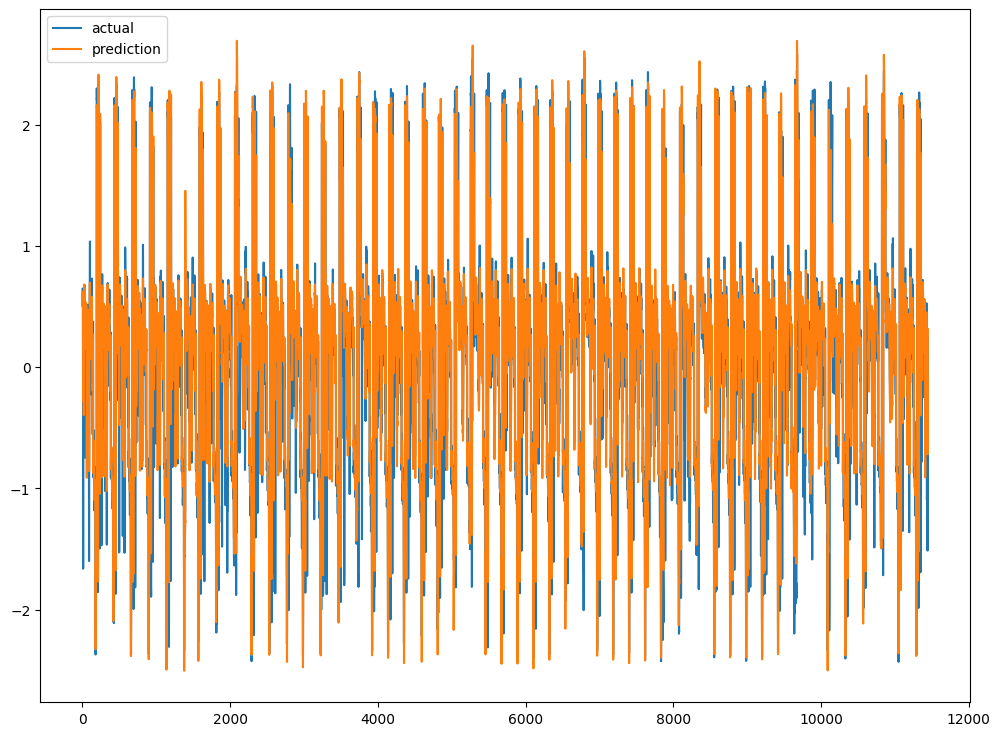

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [34]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

In [35]:
model_path = '/content/drive/MyDrive/공모전/분석'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')

In [36]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [38]:
df  = pd.read_csv('/content/drive/MyDrive/공모전/데이터/학습용/데이터변환2.csv')

In [39]:
data = df[['속도','지점번호','교통량', '요일', '방향', '거리', '차선수',
       '기능유형구분', '합류도로수', '제한속도', '주말 유무']]

In [40]:
c_data = data[data['지점번호']=='C-17']

In [41]:
c_data

,속도,지점번호,교통량,요일,방향,거리,차선수,기능유형구분,합류도로수,제한속도,주말 유무
96,89.00,C-17,520,2,0,1575,3,1,3,80,0
97,87.50,C-17,415,2,0,1575,3,1,3,80,0
98,89.67,C-17,373,2,0,1575,3,1,3,80,0
99,87.67,C-17,559,2,0,1575,3,1,3,80,0
100,88.58,C-17,1324,2,0,1575,3,1,3,80,0
...,...,...,...,...,...,...,...,...,...,...,...
73771,31.92,C-17,2692,1,1,1138,3,1,2,80,0
73772,69.67,C-17,2669,1,1,1138,3,1,2,80,0
73773,73.75,C-17,2295,1,1,1138,3,1,2,80,0
73774,78.17,C-17,1409,1,1,1138,3,1,2,80,0


In [42]:
c0_data = c_data[c_data['방향']==0]
c1_data = c_data[c_data['방향']==1]

In [43]:
mean_0 = c0_data['속도'].mean()
var_0 = c0_data['속도'].std()

In [44]:
mean_0

50.1720114483493

In [45]:
mean_1 = c1_data['속도'].mean()
var_1 = c1_data['속도'].std()

In [46]:
c1_data

,속도,지점번호,교통량,요일,방향,거리,차선수,기능유형구분,합류도로수,제한속도,주말 유무
120,93.33,C-17,451,2,1,1138,3,1,2,80,0
121,91.75,C-17,369,2,1,1138,3,1,2,80,0
122,90.50,C-17,409,2,1,1138,3,1,2,80,0
123,91.08,C-17,750,2,1,1138,3,1,2,80,0
124,90.83,C-17,2544,2,1,1138,3,1,2,80,0
...,...,...,...,...,...,...,...,...,...,...,...
73771,31.92,C-17,2692,1,1,1138,3,1,2,80,0
73772,69.67,C-17,2669,1,1,1138,3,1,2,80,0
73773,73.75,C-17,2295,1,1,1138,3,1,2,80,0
73774,78.17,C-17,1409,1,1,1138,3,1,2,80,0


In [47]:
c0_4lane = pd.DataFrame.copy(c0_data)
c0_4lane['차선수'] = 4
c0_2lane = pd.DataFrame.copy(c0_data)
c0_2lane['차선수'] = 2

In [48]:
c0_2lane

,속도,지점번호,교통량,요일,방향,거리,차선수,기능유형구분,합류도로수,제한속도,주말 유무
96,89.00,C-17,520,2,0,1575,2,1,3,80,0
97,87.50,C-17,415,2,0,1575,2,1,3,80,0
98,89.67,C-17,373,2,0,1575,2,1,3,80,0
99,87.67,C-17,559,2,0,1575,2,1,3,80,0
100,88.58,C-17,1324,2,0,1575,2,1,3,80,0
...,...,...,...,...,...,...,...,...,...,...,...
73747,28.17,C-17,3184,1,0,1575,2,1,3,80,0
73748,68.17,C-17,2877,1,0,1575,2,1,3,80,0
73749,73.25,C-17,2432,1,0,1575,2,1,3,80,0
73750,77.17,C-17,1667,1,0,1575,2,1,3,80,0


In [49]:
c1_4lane = pd.DataFrame.copy(c1_data)
c1_4lane['차선수'] = 4
c1_2lane = pd.DataFrame.copy(c1_data)
c1_2lane['차선수'] = 2

In [50]:
c0_4lane.sort_index(ascending=False).reset_index(drop=True)

scaler = StandardScaler()
scale_cols = ['속도','교통량',  '거리', '제한속도']
       #'요일', '방향','차선수', '주말 유무'
       #'기능유형구분', '합류도로수', 
c0_4lane_scaled = scaler.fit_transform(c0_4lane[scale_cols])
c0_4lane_scaled = pd.DataFrame(c0_4lane_scaled)
c0_4lane_scaled.columns = scale_cols

c0_4lane_scaled['요일'] = c0_4lane['요일']
c0_4lane_scaled['방향'] = c0_4lane['방향']
c0_4lane_scaled['차선수'] = c0_4lane['차선수']
c0_4lane_scaled['주말 유무'] = c0_4lane['주말 유무']
c0_4lane_scaled['기능유형구분'] = c0_4lane['기능유형구분']
c0_4lane_scaled['합류도로수'] = c0_4lane['합류도로수']

In [51]:
c0_2lane.sort_index(ascending=False).reset_index(drop=True)

scaler = StandardScaler()
scale_cols = ['속도','교통량',  '거리', '제한속도']
       #'요일', '방향','차선수', '주말 유무'
       #'기능유형구분', '합류도로수', 
c0_2lane_scaled = scaler.fit_transform(c0_2lane[scale_cols])
c0_2lane_scaled = pd.DataFrame(c0_2lane_scaled)
c0_2lane_scaled.columns = scale_cols

c0_2lane_scaled['요일'] = c0_2lane['요일']
c0_2lane_scaled['방향'] = c0_2lane['방향']
c0_2lane_scaled['차선수'] = c0_2lane['차선수']
c0_2lane_scaled['주말 유무'] = c0_2lane['주말 유무']
c0_2lane_scaled['기능유형구분'] = c0_2lane['기능유형구분']
c0_2lane_scaled['합류도로수'] = c0_2lane['합류도로수']

In [52]:
c1_4lane.sort_index(ascending=False).reset_index(drop=True)

scaler = StandardScaler()
scale_cols = ['속도','교통량',  '거리', '제한속도']
       #'요일', '방향','차선수', '주말 유무'
       #'기능유형구분', '합류도로수', 
c1_4lane_scaled = scaler.fit_transform(c1_4lane[scale_cols])
c1_4lane_scaled = pd.DataFrame(c1_4lane_scaled)
c1_4lane_scaled.columns = scale_cols

c1_4lane_scaled['요일'] = c1_4lane['요일']
c1_4lane_scaled['방향'] = c1_4lane['방향']
c1_4lane_scaled['차선수'] = c1_4lane['차선수']
c1_4lane_scaled['주말 유무'] = c1_4lane['주말 유무']
c1_4lane_scaled['기능유형구분'] = c1_4lane['기능유형구분']
c1_4lane_scaled['합류도로수'] = c1_4lane['합류도로수']

In [53]:
c1_2lane.sort_index(ascending=False).reset_index(drop=True)

scaler = StandardScaler()
scale_cols = ['속도','교통량',  '거리', '제한속도']
       #'요일', '방향','차선수', '주말 유무'
       #'기능유형구분', '합류도로수', 
c1_2lane_scaled = scaler.fit_transform(c1_2lane[scale_cols])
c1_2lane_scaled = pd.DataFrame(c1_2lane_scaled)
c1_2lane_scaled.columns = scale_cols

c1_2lane_scaled['요일'] = c1_2lane['요일']
c1_2lane_scaled['방향'] = c1_2lane['방향']
c1_2lane_scaled['차선수'] = c1_2lane['차선수']
c1_2lane_scaled['주말 유무'] = c1_2lane['주말 유무']
c1_2lane_scaled['기능유형구분'] = c1_2lane['기능유형구분']
c1_2lane_scaled['합류도로수'] = c1_2lane['합류도로수']

In [54]:
feature_cols = ['교통량', '요일', '방향', '거리', '차선수',
       '기능유형구분', '합류도로수', '제한속도', '주말 유무']
label_cols = ['속도']

In [55]:
test04_feature = c0_4lane_scaled[feature_cols]
test02_feature = c0_2lane_scaled[feature_cols]
test14_feature = c1_4lane_scaled[feature_cols]
test12_feature = c1_2lane_scaled[feature_cols]
test04_label = c0_4lane_scaled[label_cols]
test02_label = c0_2lane_scaled[label_cols]
test14_label = c1_4lane_scaled[label_cols]
test12_label = c1_2lane_scaled[label_cols]
#test_feature.shape, test_label.shape

In [56]:
test04_feature, test04_label = make_dataset(test04_feature, test04_label, 24)
test02_feature, test02_label = make_dataset(test02_feature, test02_label, 24)
test14_feature, test14_label = make_dataset(test14_feature, test14_label, 24)
test12_feature, test12_label = make_dataset(test12_feature, test12_label, 24)
test04_feature.shape, test04_label.shape

((7488, 24, 9), (7488, 1))

In [57]:
pred04 = model.predict(test04_feature) #상행 4차선 변경
pred02 = model.predict(test02_feature) #상행 2차선 변경
pred14 = model.predict(test14_feature) #하행 4차선 변경
pred12 = model.predict(test12_feature) #하행 2차선 변경

234/234 [==============================] - 2s 7ms/step
